In [6]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.metrics import structural_similarity as ssim

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import img_to_array
from keras.models import Sequential

from keras import layers

from skimage.metrics import structural_similarity as ssim

2023-08-16 13:33:44.611658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 13:33:44.669003: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-16 13:33:44.671901: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lcadame/mambaforge/lib/python3.10/site-packages/cv2/../../lib64:
2023-08-16 13:33:44.671

In [4]:
model_path = 'super_resolution.h5'

base_model=tf.keras.models.load_model(model_path)

2023-08-16 13:18:49.229430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-16 13:18:49.229550: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lcadame/mambaforge/lib/python3.10/site-packages/cv2/../../lib64:
2023-08-16 13:18:49.229687: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lcadame/mambaforge/lib/python3.10/site-packages/cv2/../../lib64:
2023-08-16 13:18:49.229711: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dl

In [5]:
#base_model.trainable = False

In [6]:
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600, 600, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 600, 600, 32)      7808      
                                                                 
 conv2d_1 (Conv2D)           (None, 600, 600, 16)      528       
                                                                 
 conv2d_2 (Conv2D)           (None, 600, 600, 3)       1203      
                                                                 
Total params: 9,539
Trainable params: 9,539
Non-trainable params: 0
_________________________________________________________________


In [7]:
layers = [l for l in base_model.layers]

# Insert a new layer at the second position (index 1)
layers.insert(3,tf.keras.layers.Conv2D(32,9,padding='same',activation='relu',name='newConv2d_1'))
layers.insert(4,tf.keras.layers.Conv2D(16,1,padding='same',activation='relu',name='newConv2d_2'))

# Create a new model with the modified layers
model = Sequential(layers)

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 600, 600, 32)      7808      
                                                                 
 conv2d_1 (Conv2D)           (None, 600, 600, 16)      528       
                                                                 
 newConv2d_1 (Conv2D)        (None, 600, 600, 32)      41504     
                                                                 
 newConv2d_2 (Conv2D)        (None, 600, 600, 16)      528       
                                                                 
 conv2d_2 (Conv2D)           (None, 600, 600, 3)       1203      
                                                                 
Total params: 51,571
Trainable params: 51,571
Non-trainable params: 0
_________________________________________________________________


In [9]:
SIZE=600
SUBSET_SIZE=320

In [11]:
dataset=os.listdir('real_dataset')
dataset=np.random.choice(dataset,SUBSET_SIZE,replace=False)

In [15]:
path='real_dataset/'

train_hr=[]
for img_path in tqdm(dataset):
    if img_path == '.ipynb_checkpoints':
        continue
    img=cv2.imread(path+img_path)
    img=cv2.resize(img,(SIZE,SIZE))
    img=img.astype('float32')/255
    train_hr.append(img)
train_hr=np.array(train_hr)

train_lr=[]
for img_path in tqdm(dataset):
    if img_path == '.ipynb_checkpoints':
        continue
    img=cv2.imread(path+img_path)
    img=cv2.resize(img,(100,100))
    img=cv2.resize(img,(SIZE,SIZE))
    img=img.astype('float32')/255
    train_lr.append(img)
train_lr=np.array(train_lr)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:02<00:00, 121.33it/s]


(600, 600, 3) (600, 600, 3)
0.7450926


/tmp/ipykernel_15264/85683269.py:12: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  print(ssim(img,target,multichannel=True))


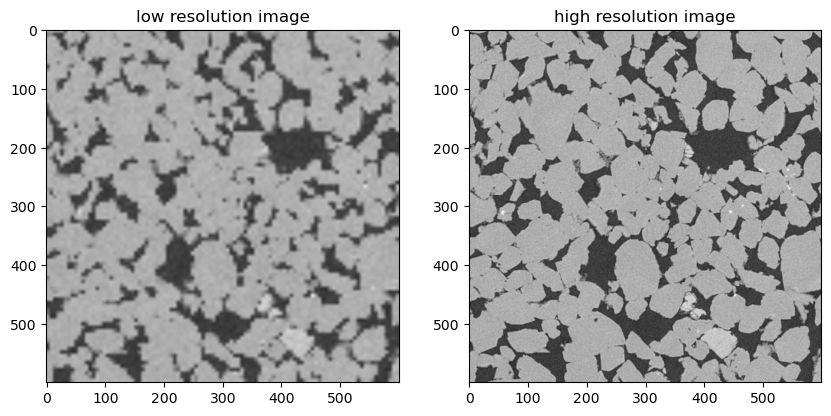

In [17]:
i=np.random.randint(0,SUBSET_SIZE)

img,target=train_lr[i],train_hr[i]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.imshow(img)
ax1.set_title('low resolution image')
ax2.imshow(target)
ax2.set_title('high resolution image')

print(img.shape,target.shape)
print(ssim(img,target,multichannel=True))

In [3]:
import tensorflow as tf

2023-08-16 13:58:37.136748: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-16 13:58:37.137834: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-16 13:58:37.158788: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-16 13:58:37.159354: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 13:58:37.528659: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3485778279794308037
xla_global_id: -1
]


2023-08-16 13:58:39.281117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-16 13:58:39.299802: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
model.fit(train_lr,train_hr,epochs=3,batch_size=1,validation_split=0.3)

Epoch 1/3


2023-08-16 13:20:31.669959: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1866240000 exceeds 10% of free system memory.
2023-08-16 13:20:31.671081: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1866240000 exceeds 10% of free system memory.


In [ ]:
model.save('super_resolution_w/transfer_learnio')